**program:** investigations<br>
**author:** chris chan<br>
**date:** jan 27,2021<br>
**desc:** use clean df for analysis <br>


In [1]:
#######################
# standard code block #
#######################

# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']

#######################
#       imports       #
#######################
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
import xgboost as xgb

sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


In [2]:
from importlib import reload
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [3]:
import matplotlib.cm as cm
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [4]:
from sqlalchemy import create_engine
import pandas as pd

In [5]:
from sklearn.model_selection import train_test_split

**1. Bring in data**

In [240]:
df=pd.read_csv(r'sb_final_df.csv')
df.head(3)

,spotifyid,danceability_x,energy,key,mode,speechiness,acousticness_x,instrumentalness_x,liveness_x,valence_x,...,acousticness_y,instrumentalness_y,liveness_y,valence_y,loudness_y,track_seconds_y,row_num,is_hit_y,y_pred,y_pred_prob
0,7dt6x5M1jzdTEt8oCbisTK,0.680,0.578,10,1,0.040,0.3310,0.000,0.135,0.341,...,0.3310,0.000,0.135,0.341,-5.804,231.267,2779,1,1.0,0.904529
1,0TlLq3lA83rQOYtrqBqSct,0.912,0.412,7,1,0.124,0.0164,0.013,0.104,0.422,...,0.0164,0.013,0.104,0.422,-8.074,238.614,2232,1,1.0,0.736371
2,3wScL5W8H40zzCKN0atfBk,0.743,0.870,1,1,0.212,0.0595,0.000,0.299,0.884,...,0.0595,0.000,0.299,0.884,-2.188,194.184,1400,1,1.0,0.799139


In [241]:
df.columns

Index(['spotifyid', 'danceability_x', 'energy', 'key', 'mode', 'speechiness',
       'acousticness_x', 'instrumentalness_x', 'liveness_x', 'valence_x',
       'tempo', 'duration_ms', 'loudness_x', 'is_hit_x', 'year', 'decade',
       'track_seconds_x', 'm_index', 'danceability_y', 'acousticness_y',
       'instrumentalness_y', 'liveness_y', 'valence_y', 'loudness_y',
       'track_seconds_y', 'row_num', 'is_hit_y', 'y_pred', 'y_pred_prob'],
      dtype='object')

In [242]:
df2 = df.drop(columns = ['danceability_x','acousticness_x', 'instrumentalness_x', 'liveness_x', 'valence_x','loudness_x', 'is_hit_x',
                        'track_seconds_x'])

df2.rename(columns={'danceability_y': 'danceability', 'acousticness_y': 'acousticness', 
                    'instrumentalness_y':'instrumentalness','liveness_y':'liveness','valence_y':'valence',
                   'loudness_y':'loudness','track_seconds_y':'track_seconds', 'is_hit_y':'is_hit'}, inplace=True)

In [243]:
df2.columns

Index(['spotifyid', 'energy', 'key', 'mode', 'speechiness', 'tempo',
       'duration_ms', 'year', 'decade', 'm_index', 'danceability',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'loudness',
       'track_seconds', 'row_num', 'is_hit', 'y_pred', 'y_pred_prob'],
      dtype='object')

**Scale first**

In [244]:
features=['spotifyid', 'energy', 'key', 'mode', 'speechiness', 'tempo',
       'duration_ms', 'year', 'decade', 'm_index', 'danceability',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'loudness',
       'track_seconds', 'row_num', 'is_hit', 'y_pred', 'y_pred_prob']

In [245]:
df3=df2.copy()

In [248]:
df3.describe()

,energy,key,mode,speechiness,tempo,duration_ms,year,decade,m_index,danceability,acousticness,instrumentalness,liveness,valence,loudness,track_seconds,row_num,is_hit,y_pred,y_pred_prob
count,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2.787000e+03,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000
mean,0.644862,5.297452,0.671690,0.093978,120.500967,2.394959e+05,2004.535343,1999.939003,7052.984212,0.597987,0.233929,0.089718,0.195349,0.521733,-7.936693,239.495944,1393.000000,0.610693,0.587729,0.604578
std,0.220449,3.614719,0.469683,0.108260,30.369279,7.712726e+04,7.633362,7.354466,4088.765988,0.168865,0.286065,0.241897,0.165484,0.243393,4.255555,77.127257,804.681925,0.487681,0.492332,0.297557
min,0.002460,0.000000,0.000000,0.000000,0.000000,6.477000e+03,1990.000000,1990.000000,1.000000,0.000000,0.000002,0.000000,0.000000,0.000000,-54.909000,6.477000,0.000000,0.000000,0.000000,0.005325
25%,0.499000,2.000000,0.000000,0.034000,96.063500,1.999425e+05,1999.000000,1990.000000,3461.000000,0.494500,0.015300,0.000000,0.094900,0.328000,-9.718500,199.942500,696.500000,0.000000,0.000000,0.381616
50%,0.677000,5.000000,1.000000,0.048600,119.989000,2.312800e+05,2005.000000,2000.000000,7103.000000,0.609000,0.095600,0.000007,0.128000,0.528000,-6.887000,231.280000,1393.000000,1.000000,1.000000,0.729427
75%,0.821000,9.000000,1.000000,0.100500,139.815500,2.680265e+05,2010.000000,2010.000000,10673.500000,0.721000,0.364000,0.002205,0.256000,0.718000,-5.132000,268.026500,2089.500000,1.000000,1.000000,0.847737
max,0.999000,11.000000,1.000000,0.949000,218.425000,1.131067e+06,2019.000000,2010.000000,14034.000000,0.984000,0.995000,0.985000,0.989000,0.989000,-0.929000,1131.067000,2786.000000,1.000000,1.000000,0.943358


**take abs val of loudness to scale**


In [249]:
df3['loudness'] = abs(df3['loudness'])
#df3['loudness'] = math.log(df3['loudness']/ (1 - df3['loudness']))

In [223]:
#features = data[col_names]
feats = df3[features]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([
#         ('ctrans', StandardScaler(), ['acousticness', 'danceability', 'energy', 'instrumentalness', 'tempo', 
#           'speechiness', 'valence','track_seconds','loudness','liveness']) # ,'liveness','track_seconds','loudness'])
        ('ctrans', StandardScaler(), ['tempo', 
          'track_seconds','loudness']) # ,'liveness','track_seconds','loudness'])

    ], remainder='passthrough')

df4=ct.fit_transform(feats)
#df4=pd.DataFrame(df3)

In [225]:
# df5=pd.DataFrame(df4,columns=['acousticness', 'danceability', 'energy', 'instrumentalness', 'tempo', 
#           'speechiness', 'valence','track_seconds','loudness','liveness',
#         'spotifyid', 'key', 'mode','duration_ms', 'year', 'decade', 'm_index',  
#         #'liveness','loudness','track_seconds',
#         'row_num', 'is_hit', 'y_pred', 'y_pred_prob'])

df5=pd.DataFrame(df4,columns=['tempo','track_seconds','loudness', 
                              'spotifyid', 'energy', 'key', 'mode', 'speechiness', 
       'duration_ms', 'year', 'decade', 'm_index', 'danceability',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 
       'row_num', 'is_hit', 'y_pred', 'y_pred_prob'])

In [226]:
df5.head()

,tempo,track_seconds,loudness,spotifyid,energy,key,mode,speechiness,duration_ms,year,...,m_index,danceability,acousticness,instrumentalness,liveness,valence,row_num,is_hit,y_pred,y_pred_prob
0,0.808101,-0.106712,-0.501245,7dt6x5M1jzdTEt8oCbisTK,0.578,10,1,0.04,231267,2018,...,1,0.68,0.331,0,0.135,0.341,2779,1,1,0.904529
1,1.13563,-0.011437,0.0322713,0TlLq3lA83rQOYtrqBqSct,0.412,7,1,0.124,238614,2018,...,11,0.912,0.0164,0.013,0.104,0.422,2232,1,1,0.736371
2,-0.705641,-0.587601,-1.35111,3wScL5W8H40zzCKN0atfBk,0.87,1,1,0.212,194184,2018,...,16,0.743,0.0595,0,0.299,0.884,1400,1,1,0.799139
3,-1.26753,-0.629578,-1.22396,1rqqCSm0Qe4I9rUvWncaom,0.904,5,1,0.0618,190947,2018,...,18,0.579,0.193,0,0.064,0.681,2238,1,1,0.887105
4,-1.13573,-0.554365,-0.518402,42fw0rxRO2xbesF6mJfd4Y,0.581,11,1,0.0281,196747,2018,...,26,0.489,0.0312,0,0.132,0.494,1389,1,1,0.873429


**create 4 diffent sets for each song**

In [273]:
from sklearn.preprocessing import MinMaxScaler
   
# song
#global dfnm    
postmal=pd.DataFrame()
postmal = df3.loc[df3['spotifyid'] == '7dt6x5M1jzdTEt8oCbisTK' ]
postmal = postmal[['acousticness',   'instrumentalness', 'tempo', 'speechiness', 'valence','energy','liveness','danceability','track_seconds','loudness']]
    
# xmas
#global dfnm    
xmas=pd.DataFrame()
xmas = df3.loc[df3['spotifyid'] == '65Q2mv3UlVi9eO70OpsmSe' ]
xmas = xmas[['acousticness',   'instrumentalness', 'tempo', 'speechiness', 'valence','energy','liveness','danceability','track_seconds','loudness']]

# beyonce
#global dfnm    
bey=pd.DataFrame()
bey = df3.loc[df3['spotifyid'] == '1BKTisxMw0p2l55xvMWkpo' ]
bey = bey[['acousticness',   'instrumentalness', 'tempo', 'speechiness', 'valence','energy','liveness','danceability','track_seconds','loudness']]

# muse
#global dfnm    
muse=pd.DataFrame()
muse = df3.loc[df3['spotifyid'] == '4VqPOruhp5EdPBeR92t6lQ' ]
muse = muse[['acousticness',   'instrumentalness', 'tempo', 'speechiness', 'valence','energy','liveness','danceability','track_seconds','loudness']]
    
    
#global dfnm    
swift=pd.DataFrame()
swift = df3.loc[df3['spotifyid'] == '7snx7w5WZLHovS0xC45ZfP' ]
swift = swift[['acousticness',   'instrumentalness', 'tempo', 'speechiness', 'valence','energy','liveness','danceability','track_seconds','loudness']]

#coldplay
coldplay=pd.DataFrame()
coldplay = df3.loc[df3['spotifyid'] == '4GKk1uNzpxIptBuaY97Dkj' ]
coldplay = coldplay[['acousticness',   'instrumentalness', 'tempo', 'speechiness', 'valence','energy','liveness','danceability','track_seconds','loudness']]



In [263]:
xmas.head()

,acousticness,instrumentalness,tempo,speechiness,valence,energy,liveness,danceability,track_seconds,loudness
68,0.579,0.0,140.467,0.0303,0.888,0.375,0.076,0.683,135.533,13.056


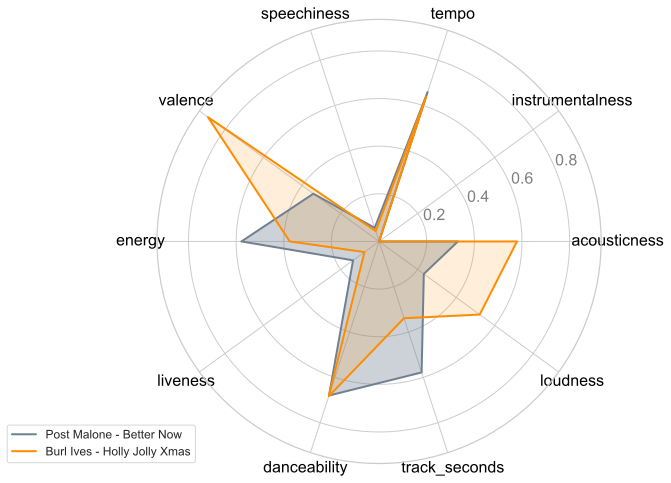

In [406]:
import math 
# plot size
#fig=plt.figure(figsize=(12,8))

# convert column names into a list
categories=list(postmal.columns)
# number of categories
N=len(categories)

# create a list with the average of all features
value = list(postmal.mean())
value2 = list(xmas.mean())

# tempo - scaled
value[2] = value[2]/220
value2[2] = value2[2]/220

# speech - scaled
value[3] = value[3]*1.5
value2[3] = value2[3]*1.5

# inst - scaled
value[1] = value[1]*2
value2[1] = value2[1]*2

# loudness - scaled
value[9] = value[9]/25
value2[9] = value2[9]/25

# time - scaled
value[8] = value[8]/400
value2[8] = value2[8]/400



# repeat first value to close the circle
# the plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
value+=value[:1]
value2+=value2[:1]

# calculate angle for each category
angles=[n/float(N)*2*math.pi for n in range(N)]
angles+=angles[:1]

# plot
fig=plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)

#plot 1 hits
ax.plot(angles, value,  linewidth=2, label = "Post Malone - Better Now", color= 'slategray')
ax.fill(angles, value, alpha=0.35, facecolor='slategray')

#plot 2 non-hits
ax.plot(angles, value2, linewidth=2, label = "Burl Ives - Holly Jolly Xmas", color = 'darkorange')
ax.fill(angles, value2, alpha=0.15, facecolor='darkorange' )
#ax.set_title('Mean Values of the audio features')
ax.grid(True)

# plt.polar(angles, value,label='hit')
# plt.fill(angles,value,alpha=0.3)

# plt.polar(angles, value2,label='non-hit',color='m')
# plt.fill(angles,value2,alpha=0.3,facecolor='m')

# plt.title('Discovery Weekly Songs Audio Features', size=35)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),fontsize='small')

plt.xticks(angles[:-1],categories, size=16,color='black')
#plt.xticks(angles[0:2], size=12,color='red')
#plt.xticks(angles[3:9:1], size=12,color='red')
# plt.xticks(angles[0:2:], size=12,color='blue')
# plt.xticks(angles[1:2:], size=12,color='red')
# plt.xticks(angles[2:3:], size=12,color='green')
plt.yticks(color='grey',size=16)

#for i in arange(0,10):
#     if i in (0,1):
#         plt.xticks(angles[i:],categories, size=12,color='red')
#     if i in (0,1,2,3,4,5,6,7,8):
#         plt.xticks(angles[i:],categories, size=12,color='blue')


# Create a color palette:
plt.cm.get_cmap("Set2", len(postmal.index))
plt.savefig('radar_post_xmas.pdf')
plt.show()

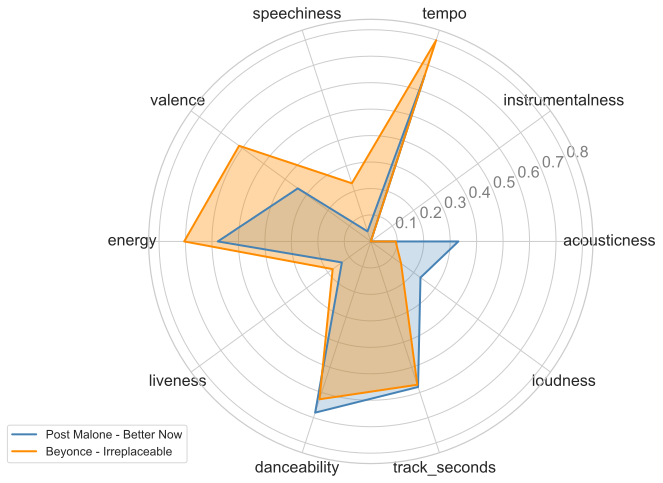

In [407]:
import math 
# plot size
#fig=plt.figure(figsize=(12,8))

# convert column names into a list
categories=list(postmal.columns)
# number of categories
N=len(categories)

# create a list with the average of all features
value = list(postmal.mean())
value2 = list(bey.mean())

# tempo - scaled
value[2] = value[2]/220
value2[2] = value2[2]/220

# speech - scaled
value[3] = value[3]
value2[3] = value2[3]

# inst - scaled
value[1] = value[1]*3
value2[1] = value2[1]*3

# loudness - scaled
value[9] = value[9]/25
value2[9] = value2[9]/25

# time - scaled
value[8] = value[8]/400
value2[8] = value2[8]/400



# repeat first value to close the circle
# the plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
value+=value[:1]
value2+=value2[:1]

# calculate angle for each category
angles=[n/float(N)*2*math.pi for n in range(N)]
angles+=angles[:1]

# plot
fig=plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)

#plot 1 hits
ax.plot(angles, value,  linewidth=2, label = "Post Malone - Better Now", color= 'steelblue')
ax.fill(angles, value, alpha=0.25, facecolor='steelblue')

#plot 2 non-hits
ax.plot(angles, value2, linewidth=2, label = "Beyonce - Irreplaceable", color = 'darkorange')
ax.fill(angles, value2, alpha=0.35, facecolor='darkorange' )
#ax.set_title('Mean Values of the audio features')
ax.grid(True)

# plt.polar(angles, value,label='hit')
# plt.fill(angles,value,alpha=0.3)

# plt.polar(angles, value2,label='non-hit',color='m')
# plt.fill(angles,value2,alpha=0.3,facecolor='m')

# plt.title('Discovery Weekly Songs Audio Features', size=35)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),fontsize='small')

plt.xticks(angles[:-1],categories, size=16)
plt.yticks(color='grey',size=16)

# Create a color palette:
plt.cm.get_cmap("Set2", len(postmal.index))


plt.savefig('radar_post_bey.pdf')
plt.show()

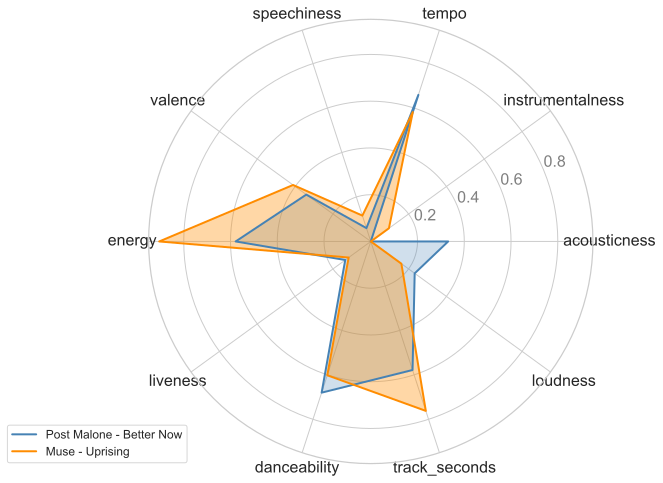

In [408]:
import math 
# plot size
#fig=plt.figure(figsize=(12,8))

# convert column names into a list
categories=list(postmal.columns)
# number of categories
N=len(categories)

# create a list with the average of all features
value = list(postmal.mean())
value2 = list(muse.mean())


# tempo - scaled
value[2] = value[2]/220
value2[2] = value2[2]/220

# speech - scaled
value[3] = value[3]*1.5
value2[3] = value2[3]*1.5

# inst - scaled
value[1] = value[1]*1.5
value2[1] = value2[1]*1.5

# loudness - scaled
value[9] = value[9]/25
value2[9] = value2[9]/25

# time - scaled
value[8] = value[8]/400
value2[8] = value2[8]/400

# repeat first value to close the circle
# the plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
value+=value[:1]
value2+=value2[:1]

# calculate angle for each category
angles=[n/float(N)*2*math.pi for n in range(N)]
angles+=angles[:1]

# plot
fig=plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)

#plot 1 hits
ax.plot(angles, value,  linewidth=2, label = "Post Malone - Better Now", color= 'steelblue')
ax.fill(angles, value, alpha=0.25, facecolor='steelblue')

#plot 2 non-hits
ax.plot(angles, value2, linewidth=2, label = "Muse - Uprising", color = 'darkorange')
ax.fill(angles, value2, alpha=0.35, facecolor='darkorange' )
#ax.set_title('Mean Values of the audio features')
ax.grid(True)

# plt.polar(angles, value,label='hit')
# plt.fill(angles,value,alpha=0.3)

# plt.polar(angles, value2,label='non-hit',color='m')
# plt.fill(angles,value2,alpha=0.3,facecolor='m')

# plt.title('Discovery Weekly Songs Audio Features', size=35)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),fontsize='small')

plt.xticks(angles[:-1],categories, size=16)
plt.yticks(color='grey',size=16)

# Create a color palette:
plt.cm.get_cmap("Set2", len(postmal.index))
plt.savefig('radar_post_muse.pdf')
plt.show()

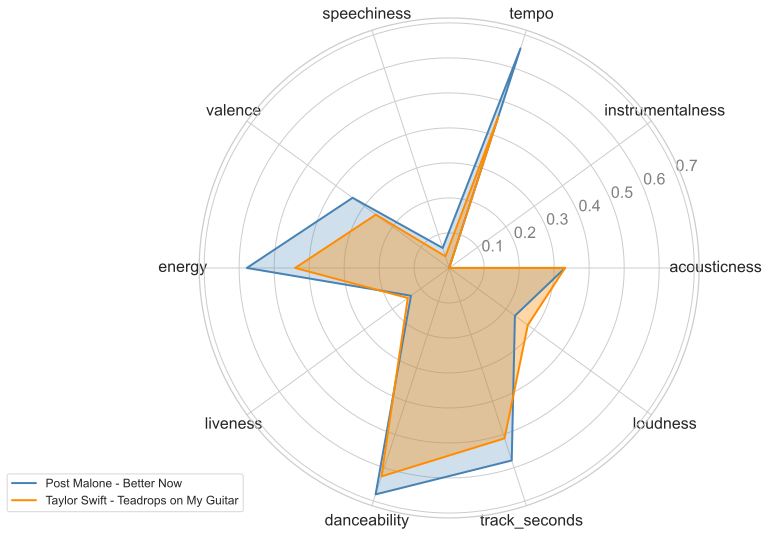

In [409]:
import math 
# plot size
#fig=plt.figure(figsize=(12,8))

# convert column names into a list
categories=list(postmal.columns)
# number of categories
N=len(categories)

# create a list with the average of all features
value = list(postmal.mean())
value2 = list(swift.mean())


# tempo - scaled
value[2] = value[2]/220
value2[2] = value2[2]/220

# speech - scaled
value[3] = value[3]*1.5
value2[3] = value2[3]*1.5

# inst - scaled
value[1] = value[1]*3
value2[1] = value2[1]*3

# loudness - scaled
value[9] = value[9]/25
value2[9] = value2[9]/25

# time - scaled
value[8] = value[8]/400
value2[8] = value2[8]/400


# repeat first value to close the circle
# the plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
value+=value[:1]
value2+=value2[:1]

# calculate angle for each category
angles=[n/float(N)*2*math.pi for n in range(N)]
angles+=angles[:1]

# plot
fig=plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)

#plot 1 hits
ax.plot(angles, value,  linewidth=2, label = "Post Malone - Better Now", color= 'steelblue')
ax.fill(angles, value, alpha=0.25, facecolor='steelblue')

#plot 2 non-hits
ax.plot(angles, value2, linewidth=2, label = "Taylor Swift - Teadrops on My Guitar", color = 'darkorange')
ax.fill(angles, value2, alpha=0.35, facecolor='darkorange' )
#ax.set_title('Mean Values of the audio features')
ax.grid(True)

# plt.polar(angles, value,label='hit')
# plt.fill(angles,value,alpha=0.3)

# plt.polar(angles, value2,label='non-hit',color='m')
# plt.fill(angles,value2,alpha=0.3,facecolor='m')

# plt.title('Discovery Weekly Songs Audio Features', size=35)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),fontsize='small')

plt.xticks(angles[:-1],categories, size=16)
plt.yticks(color='grey',size=16)

# Create a color palette:
plt.cm.get_cmap("Set2", len(postmal.index))
plt.tight_layout()
plt.savefig('radar_post_swift.pdf')
plt.show()

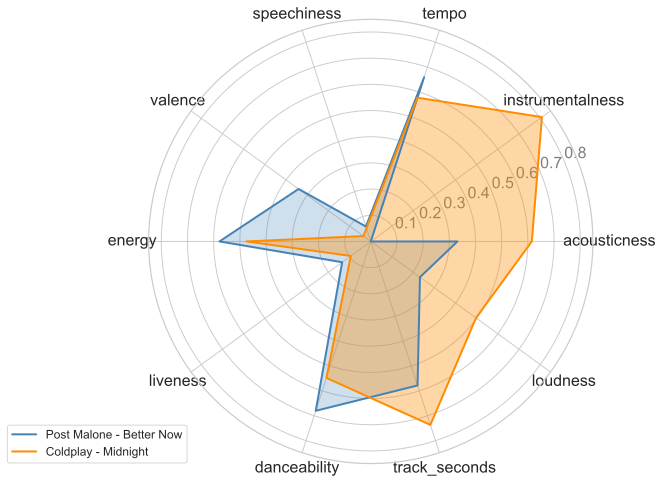

In [410]:
import math 
# plot size
#fig=plt.figure(figsize=(12,8))

# convert column names into a list
categories=list(postmal.columns)
# number of categories
N=len(categories)

# create a list with the average of all features
value = list(postmal.mean())
value2 = list(coldplay.mean())

# tempo - scaled
value[2] = value[2]/220
value2[2] = value2[2]/220

# speech - scaled
value[3] = value[3]*1.5
value2[3] = value2[3]*1.5

# inst - scaled
# value[1] = value[1]*1.5
# value2[1] = value2[1]*1.5

# loudness - scaled
value[9] = value[9]/25
value2[9] = value2[9]/25

# time - scaled
value[8] = value[8]/400
value2[8] = value2[8]/400



# repeat first value to close the circle
# the plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
value+=value[:1]
value2+=value2[:1]

# calculate angle for each category
angles=[n/float(N)*2*math.pi for n in range(N)]
angles+=angles[:1]

# plot
fig=plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)

#plot 1 hits
ax.plot(angles, value,  linewidth=2, label = "Post Malone - Better Now", color= 'steelblue')
ax.fill(angles, value, alpha=0.25, facecolor='steelblue')

#plot 2 non-hits
ax.plot(angles, value2, linewidth=2, label = "Coldplay - Midnight", color = 'darkorange')
ax.fill(angles, value2, alpha=0.35, facecolor='darkorange' )
#ax.set_title('Mean Values of the audio features')
ax.grid(True)

# plt.polar(angles, value,label='hit')
# plt.fill(angles,value,alpha=0.3)

# plt.polar(angles, value2,label='non-hit',color='m')
# plt.fill(angles,value2,alpha=0.3,facecolor='m')

# plt.title('Discovery Weekly Songs Audio Features', size=35)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),fontsize='small')

plt.xticks(angles[:-1],categories, size=16)
plt.yticks(color='grey',size=16)

# Create a color palette:
plt.cm.get_cmap("Set2", len(postmal.index))
plt.savefig('radar_post_coldplay.pdf')
plt.show()

**without scaling**


In [92]:
from sklearn.preprocessing import MinMaxScaler
   
# song
#global dfnm    
postmal2=pd.DataFrame()
postmal2 = df2.loc[df2['spotifyid'] == '7dt6x5M1jzdTEt8oCbisTK' ]
postmal2 = postmal2[['acousticness', 'danceability', 'energy', 'instrumentalness', 'speechiness', 'valence','liveness']]
    
# xmas
#global dfnm    
xmas2=pd.DataFrame()
xmas2 = df2.loc[df2['spotifyid'] == '65Q2mv3UlVi9eO70OpsmSe' ]
xmas2 = xmas2[['acousticness', 'danceability', 'energy', 'instrumentalness', 'speechiness', 'valence','liveness']]

# beyonce
#global dfnm    
bey2=pd.DataFrame()
bey2 = df2.loc[df2['spotifyid'] == '1BKTisxMw0p2l55xvMWkpo' ]
bey2 = bey2[['acousticness', 'danceability', 'energy', 'instrumentalness', 'speechiness', 'valence','liveness']]

# muse
#global dfnm    
muse2=pd.DataFrame()
muse2 = df2.loc[df2['spotifyid'] == '4VqPOruhp5EdPBeR92t6lQ' ]
muse2 = muse2[['acousticness', 'danceability', 'energy', 'instrumentalness', 'speechiness', 'valence','liveness']]
    

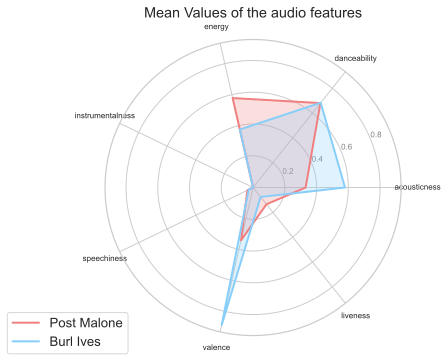

<Figure size 648x432 with 0 Axes>

In [95]:
import math 
# plot size
#fig=plt.figure(figsize=(12,8))

# convert column names into a list
categories=list(postmal2.columns)
# number of categories
N=len(categories)

# create a list with the average of all features
value = list(postmal2.mean())
value2 = list(xmas2.mean())

# repeat first value to close the circle
# the plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
value+=value[:1]
value2+=value2[:1]

# calculate angle for each category
angles=[n/float(N)*2*math.pi for n in range(N)]
angles+=angles[:1]

# plot
fig=plt.figure(figsize = (12,12))

ax = fig.add_subplot(221, polar=True)

#plot 1 hits
ax.plot(angles, value,  linewidth=2, label = "Post Malone", color= 'lightcoral')
ax.fill(angles, value, alpha=0.25, facecolor='lightcoral')

#plot 2 non-hits
ax.plot(angles, value2, linewidth=2, label = "Burl Ives", color = 'lightskyblue')
ax.fill(angles, value2, alpha=0.25, facecolor='lightskyblue' )
ax.set_title('Mean Values of the audio features')
ax.grid(True)

# plt.polar(angles, value,label='hit')
# plt.fill(angles,value,alpha=0.3)

# plt.polar(angles, value2,label='non-hit',color='m')
# plt.fill(angles,value2,alpha=0.3,facecolor='m')

# plt.title('Discovery Weekly Songs Audio Features', size=35)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.xticks(angles[:-1],categories, size=8)
plt.yticks(color='grey',size=8)

# Create a color palette:
plt.cm.get_cmap("Set2", len(postmal.index))
plt.show()

plt.savefig('radar_bad_preds.png')